## Data Validation

In [24]:
import os
%pwd

'd:\\Data Science\\END to END Proj\\Fertilizer_Pred_MLOPS'

In [2]:
os.chdir("../")

In [26]:
import pandas as pd
df_train = pd.read_csv("artifacts/data_ingestion/Fertilizer_Pred/train.csv")
df_train.drop(columns=['id'], inplace=True)

df_original = pd.read_csv("artifacts/data_ingestion/Fertilizer_Pred/Fertilizer Prediction.csv")


In [27]:
print(df_original.head())
print("=============================")
print(df_train.head())

   Temparature  Humidity  Moisture Soil Type    Crop Type  Nitrogen  \
0           32        51        41       Red  Ground Nuts         7   
1           35        58        35     Black       Cotton         4   
2           27        55        43     Sandy    Sugarcane        28   
3           33        56        56     Loamy  Ground Nuts        37   
4           32        70        60       Red  Ground Nuts         4   

   Potassium  Phosphorous Fertilizer Name  
0          3           19        14-35-14  
1         14           16            Urea  
2          0           17           20-20  
3          5           24           28-28  
4          6            9        14-35-14  
   Temparature  Humidity  Moisture Soil Type  Crop Type  Nitrogen  Potassium  \
0           37        70        36    Clayey  Sugarcane        36          4   
1           27        69        65     Sandy    Millets        30          6   
2           29        63        32     Sandy    Millets        24    

In [28]:
print(df_original.info())
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Temparature      100000 non-null  int64 
 1   Humidity         100000 non-null  int64 
 2   Moisture         100000 non-null  int64 
 3   Soil Type        100000 non-null  object
 4   Crop Type        100000 non-null  object
 5   Nitrogen         100000 non-null  int64 
 6   Potassium        100000 non-null  int64 
 7   Phosphorous      100000 non-null  int64 
 8   Fertilizer Name  100000 non-null  object
dtypes: int64(6), object(3)
memory usage: 6.9+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Temparature      750000 non-null  int64 
 1   Humidity         750000 non-null  int64 
 2   Moisture         750000 non-nul

In [29]:
print(df_train.isnull().sum())
print(df_original.isnull().sum())

Temparature        0
Humidity           0
Moisture           0
Soil Type          0
Crop Type          0
Nitrogen           0
Potassium          0
Phosphorous        0
Fertilizer Name    0
dtype: int64
Temparature        0
Humidity           0
Moisture           0
Soil Type          0
Crop Type          0
Nitrogen           0
Potassium          0
Phosphorous        0
Fertilizer Name    0
dtype: int64


In [30]:
print(df_original.columns)
print(df_train.columns)

Index(['Temparature', 'Humidity', 'Moisture', 'Soil Type', 'Crop Type',
       'Nitrogen', 'Potassium', 'Phosphorous', 'Fertilizer Name'],
      dtype='object')
Index(['Temparature', 'Humidity', 'Moisture', 'Soil Type', 'Crop Type',
       'Nitrogen', 'Potassium', 'Phosphorous', 'Fertilizer Name'],
      dtype='object')


In [31]:
print("Unique values in train.csv:")
for col in df_train.columns:
    print(f"{col}: {df_train[col].nunique()}")

print("\nUnique values in fertilizer-prediction.csv:")
for col in df_original.columns:
    print(f"{col}: {df_original[col].nunique()}")


Unique values in train.csv:
Temparature: 14
Humidity: 23
Moisture: 41
Soil Type: 5
Crop Type: 11
Nitrogen: 39
Potassium: 20
Phosphorous: 43
Fertilizer Name: 7

Unique values in fertilizer-prediction.csv:
Temparature: 14
Humidity: 23
Moisture: 41
Soil Type: 5
Crop Type: 11
Nitrogen: 39
Potassium: 20
Phosphorous: 43
Fertilizer Name: 7


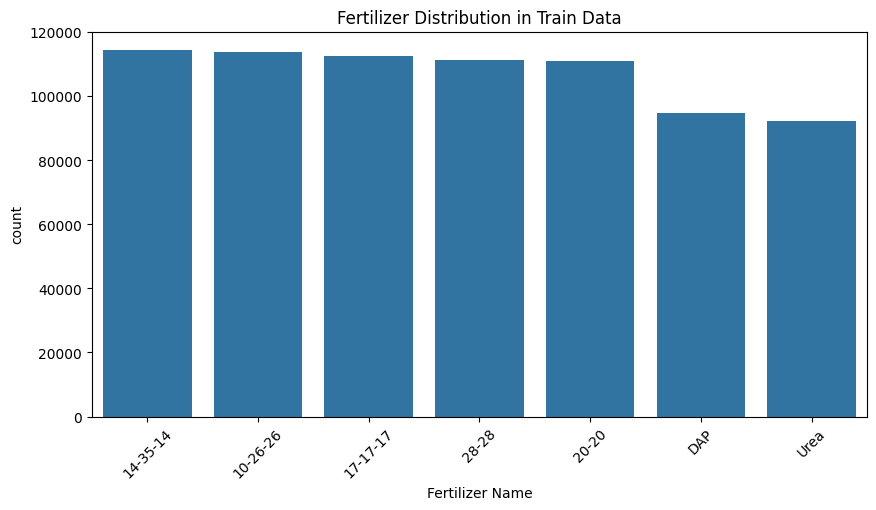

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 5))
sns.countplot(data=df_train, x='Fertilizer Name', order=df_train['Fertilizer Name'].value_counts().index)
plt.title("Fertilizer Distribution in Train Data")
plt.xticks(rotation=45)
plt.show()


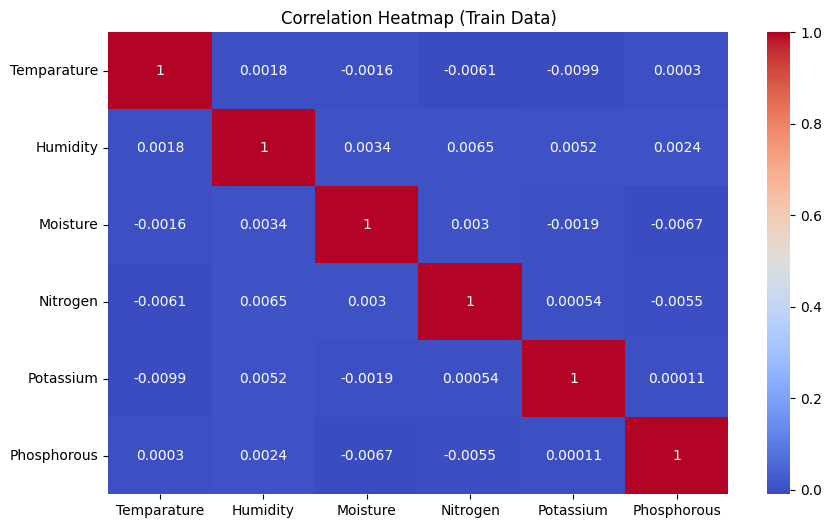

In [33]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_train.select_dtypes(include='number').corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap (Train Data)")
plt.show()


In [34]:
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class DataValidationConfig:
    root_dir: Path
    STATUS_FILE: str
    train_data_path: Path
    original_data_path: Path
    all_schema: dict


In [35]:
from src.Fertilizer_Pred.utils.common import read_yaml, create_directories
from src.Fertilizer_Pred.constant import *

class ConfigurationManager:
    def __init__(
        self,
        config_filepath=CONFIG_FILE_PATH,
        params_filepath=PARAMS_FILE_PATH,
        schema_filepath=SCHEMA_FILE_PATH
    ):
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        self.schema = read_yaml(schema_filepath)

        create_directories([self.config.artifacts_root])

    def get_data_validation_config(self) -> DataValidationConfig:
        config = self.config.data_validation
        schema = self.schema.COLUMNS

        create_directories([config.root_dir])

        return DataValidationConfig(
            root_dir=config.root_dir,
            STATUS_FILE=config.STATUS_FILE,
            train_data_path=config.train_data_path,
            original_data_path=config.original_data_path,
            all_schema=schema
        )


In [36]:
import pandas as pd

class DataValidation:
    def __init__(self, config: DataValidationConfig):
        self.config = config

    def validate_all_columns(self) -> bool:
        try:
            validation_status = True
            expected_columns = set(self.config.all_schema.keys())

            # Validate both train and original datasets
            for file_path in [self.config.train_data_path, self.config.original_data_path]:
                df = pd.read_csv(file_path)

                # Drop 'id' column if present
                if 'id' in df.columns:
                    df.drop(columns=['id'], inplace=True)

                actual_columns = set(df.columns)

                if not expected_columns.issubset(actual_columns):
                    validation_status = False
                    break

            # Write result to status file
            with open(self.config.STATUS_FILE, 'w') as f:
                f.write(f"Validation status: {validation_status}")

            return validation_status

        except Exception as e:
            raise e


In [37]:
try:
    config = ConfigurationManager()
    data_validation_config = config.get_data_validation_config()
    validator = DataValidation(config=data_validation_config)
    validator.validate_all_columns()
except Exception as e:
    raise e

[2025-07-09 12:03:31,069: INFO: common: yaml file: config\config.yaml loaded successfully]
[2025-07-09 12:03:31,075: INFO: common: yaml file: params.yaml loaded successfully]
[2025-07-09 12:03:31,088: INFO: common: yaml file: schema.yaml loaded successfully]
[2025-07-09 12:03:31,092: INFO: common: created directory at: artifacts]
[2025-07-09 12:03:31,096: INFO: common: created directory at: artifacts/data_validation]
